In [1]:
# Generic OpenAI-compatible endpoint using ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from IPython.display import Image, display

import os
default_model_name = os.environ["OPENAI_MODEL"]
pg_connection = os.environ["PGVECTOR_CONNECTION_STRING"]
llm = ChatOpenAI(model=default_model_name,temperature=0)

In [ ]:
def print_messages(result, last_n=None):
    """
    Fungsi untuk menampilkan pesan.
    Jika last_n diisi (misal: 2), hanya menampilkan n pesan terakhir.
    """
    messages = result.get("messages", [])
    
    # Jika last_n diberikan, kita slice list-nya (misal: messages[-2:])
    if last_n is not None:
        messages = messages[-last_n:]
    
    for msg in messages:
        if "type" in msg:
            role = "😎 USER" if msg.type == "human" else "🤖 BOT"
            print(f"{role}: {msg.content}")

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\pydantic\_internal\_generate_schema.py:937: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `BaseMessage` to V2.
  warnings.warn(


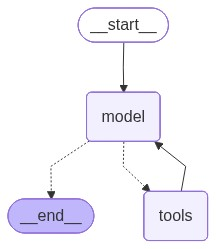

In [3]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def calculator(query: str) -> str:
    """Alat kalkulator sederhana. Masukan harus berupa ekspresi matematika."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]
model = ChatOpenAI(model=default_model_name,temperature=0.1).bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()
png_bytes =graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

In [8]:
input = {
    "messages": [
        HumanMessage("""Berapa usia jennie saat bergabung dengan blackpink ?""")
    ]
}
for c in graph.stream(input):
    print(c)

{'model': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_79439556', 'function': {'arguments': '{"query":"How old was Jennie Kim when Blackpink debuted"}', 'name': 'duckduckgo_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 277, 'prompt_tokens': 440, 'total_tokens': 717, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 242, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 148, 'video_tokens': 0}, 'cost': 1.0215e-05, 'is_byok': True, 'cost_details': {'upstream_inference_cost': 0.0002043, 'upstream_inference_prompt_cost': 6.58e-05, 'upstream_inference_completions_cost': 0.0001385}}, 'model_name': 'x-ai/grok-4-fast', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-598129c5-6914-42aa-9381-6037d3216622-0', tool_calls=[{'name'

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='Feb 19, 2025 · 升级win11后，windows.old文件夹可以删除。以下是删除windows.old的五种方法： 方法一：从文件资源管理器删除 - 打开文件资源管理器（Windows+E）。- 转到C盘，选 … May 2, 2025 · c盘windows.old文件夹可以删除。以下是关于windows.old文件夹及其删除方法的详细解答： 一、windows.old文件夹内容 windows.old文件夹里面包含的是以往系统和安装程序 … Jul 24, 2024 · Windows.old是Windows系统更新或重装后留下的旧系统文件夹，通常可以删除，但需要谨慎操作。 以下是关于Windows.old文件夹的 一、Windows.old文件夹的含义 … 电脑从 Window 10 升级到了 Window 11 后，发现系统 C 盘剩余空间小了很多，于是查看了一番，发现了一个占用空间超大的 Window.old， 这个文件夹是旧系统文件，如果不准备回退到以 … Jan 26, 2024 · 有old, old, elder, elderly四个单词，有什么区别吗？这四个单词都有“老的、年长的”含义，但是根据不同的语境，它们在平时生活中的用法是不一样的。1、old 这个词最常见的 …', name='duckduckgo_search', id='4a9fce77-fcb0-4f8f-8274-e25bb1e41bbd', tool_call_id='call_79439556')]}}
{'model': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_38413072', 'function': {'arguments': '{"query":"Jennie Kim birthdate and Blackpink debut date"}', 'name': 'duckduckgo_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='我确实长得挺不乖的（笑）”（出自电台的一次主持人和她开玩笑说Jennie长得最不听话了，妮的回答） 53.妮是老司机，只要开车次次秒懂（出自团综和2020跨年直播） 54.妮在练习生期间想过最多的是 … BLACKPINK Jennie的新专辑《Ruby》获得了广泛关注，客观评价为主，不尬黑，不尬吹。 Mar 6, 2025 · 再来是《like JENNIE》，这首歌其他都不评价了，咱就说一点，这个"Jennie, Jennie, Jennie, Jennie, Jennie, Jennie"，听着是不是有点耳熟，来，如果是B友的话， "Burnice Burnice … Feb 10, 2025 · 知乎，中文互联网高质量的问答社区和创作者聚集的原创内容平台，于 2011 年 1 月正式上线，以「让人们更好的分享知识、经验和见解，找到自己的解答」为品牌使命。知乎凭借认真、专 … jennie 2012年8月30日，金智妮的Rap曲《Who \'s that girl》公开；9月1日，金智妮参演G-Dragon个人单曲《那XX》的MV；11月22日，金智妮参与李夏怡《稻草人》的feat。', name='duckduckgo_search', id='652bcd00-cddc-4434-b7c6-9307d95dcfc6', tool_call_id='call_38413072')]}}
{'model': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_59084424', 'function': {'arguments': '{"query":"Jennie Kim age when she joined Blackpink"}', 'name': 'duckduckgo_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 654, 'prompt_tokens': 111

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='我确实长得挺不乖的（笑）”（出自电台的一次主持人和她开玩笑说Jennie长得最不听话了，妮的回答） 53.妮是老司机，只要开车次次秒懂（出自团综和2020跨年直播） 54.妮在练习生期间想过最多的是 … BLACKPINK Jennie的新专辑《Ruby》获得了广泛关注，客观评价为主，不尬黑，不尬吹。 Mar 6, 2025 · 再来是《like JENNIE》，这首歌其他都不评价了，咱就说一点，这个"Jennie, Jennie, Jennie, Jennie, Jennie, Jennie"，听着是不是有点耳熟，来，如果是B友的话， "Burnice Burnice … Feb 10, 2025 · 知乎，中文互联网高质量的问答社区和创作者聚集的原创内容平台，于 2011 年 1 月正式上线，以「让人们更好的分享知识、经验和见解，找到自己的解答」为品牌使命。知乎凭借认真、专 … jennie 2012年8月30日，金智妮的Rap曲《Who \'s that girl》公开；9月1日，金智妮参演G-Dragon个人单曲《那XX》的MV；11月22日，金智妮参与李夏怡《稻草人》的feat。', name='duckduckgo_search', id='f44c47a7-d008-49eb-8a4d-107857a9c0f5', tool_call_id='call_59084424')]}}
{'model': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_95731281', 'function': {'arguments': '{"query":"Jennie Kim birthdate"}', 'name': 'duckduckgo_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 349, 'prompt_tokens': 1448, 'total_tokens': 1

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='我确实长得挺不乖的（笑）”（出自电台的一次主持人和她开玩笑说Jennie长得最不听话了，妮的回答） 53.妮是老司机，只要开车次次秒懂（出自团综和2020跨年直播） 54.妮在练习生期间想过最多的是我什么时候 … BLACKPINK Jennie的新专辑《Ruby》获得了广泛关注，客观评价为主，不尬黑，不尬吹。 Mar 6, 2025 · 再来是《like JENNIE》，这首歌其他都不评价了，咱就说一点，这个"Jennie, Jennie, Jennie, Jennie, Jennie, Jennie"，听着是不是有点耳熟，来，如果是B友的话， "Burnice Burnice Burnice Burnice … Feb 10, 2025 · 知乎，中文互联网高质量的问答社区和创作者聚集的原创内容平台，于 2011 年 1 月正式上线，以「让人们更好的分享知识、经验和见解，找到自己的解答」为品牌使命。知乎凭借认真、专业、友善的 … jennie 2012年8月30日，金智妮的Rap曲《Who \'s that girl》公开；9月1日，金智妮参演G-Dragon个人单曲《那XX》的MV；11月22日，金智妮参与李夏怡《稻草人》的feat。', name='duckduckgo_search', id='d6f49a1c-aba3-447f-be12-4b6e5c42300f', tool_call_id='call_95731281')]}}
{'model': {'messages': AIMessage(content='Jennie Kim lahir pada 16 Januari 1996, dan Blackpink debut pada 15 Agustus 2016. Saat debut, Jennie berusia 20 tahun.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 678, 'prompt_tokens': 1787, 'total_tokens': 2465, 'completion_token